# ConvNet for Beer Crown Defects Classification

This model is generated based on CS230 course 4 Week 1 program assignment. The goal is to build a CNN model that can classify beer crown based on their differences: color, text, date code, and defects such as crimp flare, and scratches. Instead of pixel feature, this model uses convolution filters for model training. 

The model is *CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> SOFTMAX*. 

The `forward_propagation` function model:

In detail, use the following parameters for all the steps:
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - Flatten the previous output.
 - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 

The procedure:
- Implement helper functions used when implementing a TensorFlow model
- Implement a fully functioning ConvNet using TensorFlow 


The model training includes the following items: 
    1. Hyper parameter optimization; 
    2. Number of layers test; 
    3. Training time and Run time test; 
    4. Test the minimum amount of images needed for a good model; 
    5. Test the minimum amount of sample bottles needed for a good model; 
    6. Test the minimum resolution of image needed for a good training. 
    



In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(1)

# Functions for load_dataset


In [2]:
# X - Features
# y - labels
# datasets - full size of datasets: train set 400 images, test set 100 images
# datasets_mini - partial size of datasets: train set 20 images, test set 10 images

def load_dataset():
    train_dataset = h5py.File('datasets_mini/train_crown.h5', "r")
    train_set_x_orig = np.array(train_dataset["X"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["y"][:]) # train set labels

    test_dataset = h5py.File('datasets_mini/test_crown.h5', "r")
    test_set_x_orig = np.array(test_dataset["X"][:])   # test set features
    test_set_y_orig = np.array(test_dataset["y"][:])   # test set labels

    #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    classes = np.array([0,1,2,3,4,5])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

# prediction function
#def predict(X, parameters):
    
#    W1 = tf.convert_to_tensor(parameters["W1"])
#    b1 = tf.convert_to_tensor(parameters["b1"])
#    W2 = tf.convert_to_tensor(parameters["W2"])
#    b2 = tf.convert_to_tensor(parameters["b2"])
#    W3 = tf.convert_to_tensor(parameters["W3"])
#    b3 = tf.convert_to_tensor(parameters["b3"])
   
#    params = {"W1": W1,
#              "b1": b1,
#              "W2": W2,
#              "b2": b2,
#              "W3": W3,
#              "b3": b3}

#    params = {"W1": W1,
#              "b1": b1,
#              "W2": W2,
#              "b2": b2}    
    
#    x = tf.placeholder("float", [12288, 1])
    
#    z3 = forward_propagation(x, params)
#    p = tf.argmax(z3)
    
#    with tf.Session() as sess:
#        prediction = sess.run(p, feed_dict = {x: X})
        
#    return prediction

# 1. Load the dataset by calling laod_dataset.

In [3]:
# Loading the data
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

The 6 classes and its labels in the dataset.

<img src="images/crowns.png" style="width:800px;height:442px;">

Visually validate if the images features and labels are saved and loaded correctly. 

y = 5


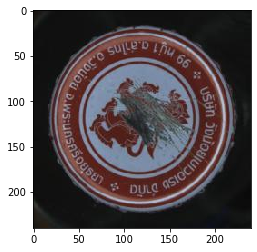

In [4]:
# Example of a picture
index = 8
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Normalize the image data. Examine the shapes of your data. 

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
#print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of test examples = " + str(X_test.shape[0]))
#print ("X_train shape: " + str(X_train.shape))
#print ("Y_train shape: " + str(Y_train.shape))
#print ("X_test shape: " + str(X_test.shape))
#print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

# 2. Create placeholders

Create placeholders for the input data that will be fed into the model when running the session.

In [6]:

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder("float", [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder("float", [None, n_y])
    
    return X, Y

In [7]:
X, Y = create_placeholders(240, 240, 3, 6)
#print ("X = " + str(X))
#print ("Y = " + str(Y))

# 3. Initialize parameters

Initialize weights/filters $W1$ and $W2$. TensorFlow functions take care of the bias variables. Only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically.

Two initialization methods are tested: Xavier, and He

In [8]:
INITIALIZER = "Xavier"
#INITIALIZER = "He"

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function to make the grading simpler.
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)   
        
    # Xavier initialization
    if INITIALIZER == "Xavier": 
        W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
        W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))

    # He_normal initialization
    if INITIALIZER == "He": 
        W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer =  tf.contrib.layers.variance_scaling_initializer(seed = 0))
        W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer =  tf.contrib.layers.variance_scaling_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    #print("W1[1,1,1] = \n" + str(parameters["W1"].eval()[1,1,1]))
    #print("W1.shape: " + str(parameters["W1"].shape))
    #print("\n")
    #print("W2[1,1,1] = \n" + str(parameters["W2"].eval()[1,1,1]))
    #print("W2.shape: " + str(parameters["W2"].shape))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# 4. Forward propagation

Use the following built-in functions to implement the convolutional forward propagation steps.

- **tf.nn.conv2d(X,W, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W$, this function convolves $W$'s filters on X. The third parameter ([1,s,s,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). Normally, we'll choose a stride of 1 for the number of examples (the first value) and for the channels (the fourth value), which is why we wrote the value as `[1,s,s,1]`. Read the full documentation on [conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d).

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, we usually operate on a single example at a time and a single channel at a time.  So the first and fourth value in `[1,f,f,1]` are both 1.  Read the full documentation on [max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool).

- **tf.nn.relu(Z):** computes the elementwise ReLU of Z (which can be any shape). We can read the full documentation on [relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu).

- **tf.contrib.layers.flatten(P)**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  
    * If a tensor P has the shape (m,h,w,c), where m is the number of examples (the batch size), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    * For example, given a tensor with dimensions [100,2,3,4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  Read the full documentation on [flatten](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten).

- **tf.contrib.layers.fully_connected(F, num_outputs):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [full_connected](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected).

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as train the model. Hence, don.t need to initialize those weights when initializing the parameters.


In [9]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn=None)

    return Z3

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(240, 240, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,240,240,3), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Z3 = 
[[-2.1500592   0.74051267 -3.2570162   1.0953593   0.35571325 -0.25095662]
 [-2.4512208   0.7999572  -3.202391    0.90437055  0.5253889  -0.0149838 ]]


# 5. Compute cost

Use these two functions to computer cost: 

- *tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y):* computes the softmax activation function as well as the resulting loss. 
- *tf.reduce_mean:* computes the mean of elements across dimensions of a tensor. Use this to calculate the sum of the losses over all the examples to get the overall cost.

Details on softmax_cross_entropy_with_logits (optional reading):
* Softmax is used to format outputs so that they can be used for classification.  It assigns a value between 0 and 1 for each category, where the sum of all prediction values (across all possible categories) equals 1.
* Cross Entropy is compares the model's predicted classifications with the actual labels and results in a numerical value representing the "loss" of the model's predictions.
* "Logits" are the result of multiplying the weights and adding the biases.  Logits are passed through an activation function (such as a relu), and the result is called the "activation."
* The function is named `softmax_cross_entropy_with_logits` takes logits as input (and not activations); then uses the model to predict using softmax, and then compares the predictions with the true labels using cross entropy.  These are done with a single function to optimize the calculations.


In [11]:

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(240, 240, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,240,240,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = -0.052395403


# 6. Model 

Merge the sub functions to build a model, which include:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

And create a session and run a for loop for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function.

#### Adam Optimizer
Use `tf.train.AdamOptimizer(learning_rate = ...)` to create the optimizer.  The optimizer has a `minimize(loss=...)` function to set the cost function that the optimizer will minimize.

#### Random mini batches
This function returns a list of mini-batches. It is implemented in the `cnn_utils.py` file and imported here:
```Python
minibatches = random_mini_batches(X, Y, mini_batch_size = 64, seed = 0)
```

#### Evaluating the optimizer and cost

Within a loop, for each mini-batch, use the `tf.Session` object (named `sess`) to feed a mini-batch of inputs and labels into the neural network and evaluate the tensors for the optimizer as well as the cost.  Built a graph data structure and feed it inputs and labels and use `sess.run()` in order to get values for the optimizer and cost.

In [16]:
# learning_rate = 0.009, num_epochs = 100, minibatch_size = 64,
# global variables
LEARNING_RATE  = 0.009 # 0.009 0.005 0.002 0.001
NUM_EPOCHS     = 20  # 100 80 40 20
MINIBATCH_SIZE = 64  # 32 16

def model(X_train, Y_train, X_test, Y_test, learning_rate = LEARNING_RATE,
          num_epochs = NUM_EPOCHS, minibatch_size = MINIBATCH_SIZE, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    #W1 = tf.get_variable("W1", [m, n_H0, n_W0, n_C0], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    #W2 = tf.get_variable("W2", [m, n_H0, n_W0, n_C0], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    #parameters = {"W1": W1,
    #              "W2": W2}
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost) 
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                _ , temp_cost =  sess.run(      fetches=[optimizer, cost],
                                                feed_dict={X: minibatch_X, Y: minibatch_Y}
                                                )
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Train the model. And track the totoal training time needed.

In [ ]:
import time
tic = time.perf_counter()

_, _, parameters = model(X_train, Y_train, X_test, Y_test)

toc = time.perf_counter()
print("Run time = " + str(toc-tic) +"s")

Cost after epoch 0: 1.601214


# 7. Evaluate with Images
Input images and visually check if the prediction is correct.

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

# define sample image name and folder
my_image = "validate_0.bmp"
fname = "images/" + my_image

tic = time.perf_counter()
# read image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255. # this can be commented out
my_image = scipy.misc.imresize(image, size=(240,240)).reshape((1, 240*240*3)).T
my_image_prediction = predict(my_image, parameters)
toc = time.perf_counter()

print("Run time = " + str((toc-tic)*1000) +"ms")
plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

In [ ]:
fname = "validate_0.bmp"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(240,240))
plt.imshow(my_image)

The End.